In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
import re
import inspect
from varname import varname
%matplotlib inline

In [2]:
df = pd.read_csv("data.csv")

# EDA

In [3]:
# Drop the last column, which is unnamed, and the "id" column, which should have no effect on diagnosis
df = df.drop(columns=["id"]).iloc[:, :-1]

In [4]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [5]:
# create a random state
rs = 123

In [6]:
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [7]:
X = df.iloc[:, 1:] # first column is the variable that we want to predict
y = df.iloc[:, :1]
feature_cols = X.columns

In [8]:
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [9]:
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [10]:
y

,diagnosis
0,M
1,M
2,M
3,M
4,M
...,...
564,M
565,M
566,M
567,M


In [11]:
y.value_counts(normalize=True)
# most of the cancer is benign versus malignant

diagnosis
B            0.627417
M            0.372583
dtype: float64

<AxesSubplot:xlabel='diagnosis'>

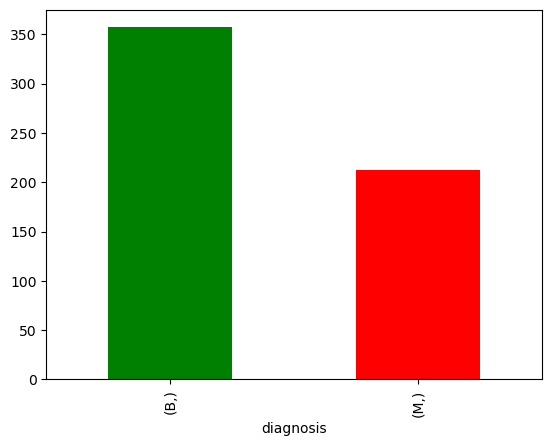

In [12]:
y.value_counts().plot.bar(color=['green', 'red'])
# chose green for benign because it's less harmful than malignant cancer, which was given red

# Feature Engineering

In [13]:
mm_scaler = MinMaxScaler()
le = LabelEncoder()

In [14]:
X = mm_scaler.fit_transform(X)
y = le.fit_transform(y.values.ravel())
np.unique(y, return_counts=True)
#print(X.min(), X.max())

(array([0, 1]), array([357, 212]))

# Logistic Regression

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

In [16]:
#def varname(p):
#  for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
#    m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
#    if m:
#      return m.group(1)

lst = [X_train, X_test, y_train, y_test]
names_lst = ["X_train", "X_test", "y_train", "y_test"]
for i in lst:
    #varname(i)
    #print(f"{varname(i)} is {i.shape}")
    print(i.shape)
    #print(varname(), f"is {i.shape}")

#varname(X_train)


(455, 30)
(114, 30)
(455,)
(114,)


In [17]:
def train_model(r, p, mc, s, mi):
    m = LogisticRegression(random_state=r, penalty=p, multi_class=mc, solver=s, max_iter=mi)
    m.fit(X_train, y_train)
    return [m, m.predict(X_test)]

In [18]:
def report_scores(pred, actual):
    result = {}
    a, r, p, f = 'accuracy', 'recall', 'precision', 'f1score'
    r1, p1, f1, _ = precision_recall_fscore_support(actual, pred)
    result[a] = accuracy_score(actual, pred)
#    for i, j in zip([r, p, f], [r1, p1, f1]):
    for i, j in zip([r, p, f], precision_recall_fscore_support(actual, pred)[:3]):
        result[i] = j
    return result

In [19]:
# previous code before creating function "train_model"
#l2_m = LogisticRegression(random_state=rs, penalty='l2', multi_class='ovr', solver='lbfgs', 
#                         max_iter=1000)
#l2_m.fit(X_train, y_train)
#l2_p = l2_m.predict(X_test)

In [20]:
o, n, lb, li, s1, s2 = 'ovr', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 
l2_params = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
l1_params = ['liblinear', 'saga']


print('----------------------------------------')
print('Using l2 as penalty')
for i in l2_params:
    l2_m, l2_p = train_model(rs, 'l2', 'ovr', i, 1000)
    print(f"{i} solver: {report_scores(l2_p, y_test)}")
print('----------------------------------------')
print('Using l2 as penalty')
for i in l1_params:
    mi = 1000 if i == 'liblinear' else 10000
    l1_m, l1_p = train_model(rs, 'l1', 'ovr', i, mi)
    print(f"{i} solver: {report_scores(l1_p, y_test)}")

----------------------------------------
Using l2 as penalty
newton-cg solver: {'accuracy': 0.9649122807017544, 'recall': array([0.97222222, 0.95238095]), 'precision': array([0.97222222, 0.95238095]), 'f1score': array([0.97222222, 0.95238095])}
lbfgs solver: {'accuracy': 0.9649122807017544, 'recall': array([0.97222222, 0.95238095]), 'precision': array([0.97222222, 0.95238095]), 'f1score': array([0.97222222, 0.95238095])}
liblinear solver: {'accuracy': 0.9736842105263158, 'recall': array([0.98591549, 0.95348837]), 'precision': array([0.97222222, 0.97619048]), 'f1score': array([0.97902098, 0.96470588])}
sag solver: {'accuracy': 0.9649122807017544, 'recall': array([0.97222222, 0.95238095]), 'precision': array([0.97222222, 0.95238095]), 'f1score': array([0.97222222, 0.95238095])}
saga solver: {'accuracy': 0.9649122807017544, 'recall': array([0.97222222, 0.95238095]), 'precision': array([0.97222222, 0.95238095]), 'f1score': array([0.97222222, 0.95238095])}
----------------------------------

In [21]:
lr_dict = {
    'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1'
    : ['liblinear', 'saga'],
}

In [51]:
# to be plotted as bar graph later
accuracy_names = []
accuracy_scores = [] 
for i in lr_dict.keys(): 
    for j in lr_dict[i]:
        mi = 10000 if i == 'l1' and j == 'saga' else 1000
        m, pred = train_model(rs, i, 'ovr', j, mi)
        scores = report_scores(pred, y_test)
        accuracy_names.append(i + ' ' + j)
        accuracy_scores.append(scores['accuracy'])

In [52]:
accuracy_names

['l2 newton-cg',
 'l2 lbfgs',
 'l2 liblinear',
 'l2 sag',
 'l2 saga',
 'l1 liblinear',
 'l1 saga']

In [53]:
accuracy_scores

[0.9649122807017544,
 0.9649122807017544,
 0.9736842105263158,
 0.9649122807017544,
 0.9649122807017544,
 0.956140350877193,
 0.9473684210526315]

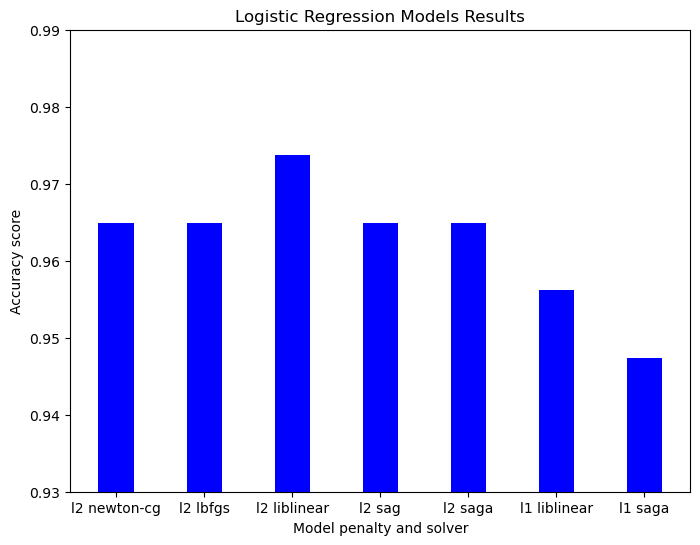

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))


y_low = round(min(accuracy_scores), 2) - 0.02
y_high = round(max(accuracy_scores), 2) + 0.02
plt.ylim([y_low, y_high])
#ax.set_yticks(accuracy_scores)

plt.xlabel("Model penalty and solver")
plt.ylabel("Accuracy score")

plt.bar(accuracy_names, accuracy_scores, color='blue', width=0.4)
plt.title("Logistic Regression Models Results")
plt.show()

# l2 & liblinear shows the highest accuracy

In [ ]:
l2_m, l2_p = train_model(rs, 'l2', 'ovr', 'lbfgs', 1000)
report_scores(l2_p, y_test)

In [ ]:
l2_m, l2_p = train_model(rs, 'l2', 'ovr', 'liblinear', 1000)
report_scores(l2_p, y_test)

In [ ]:
l2_m, l2_p = train_model(rs, 'l2', 'ovr', 'sag', 1000)
report_scores(l2_p, y_test)

In [ ]:
l2_m, l2_p = train_model(rs, 'l2', 'ovr', 'saga', 1000)
report_scores(l2_p, y_test)

In [ ]:
l1_m, l1_p = train_model(rs, 'l1', 'ovr', 'liblinear', 1000)
report_scores(l1_p, y_test)

In [ ]:
l1_m, l1_p = train_model(rs, 'l1', 'ovr', 'saga', 10000)
report_scores(l1_p, y_test)